In [1]:
import sys
!{sys.executable} -m pip install scikit-image

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import IPython.display as ipd
from environment import *

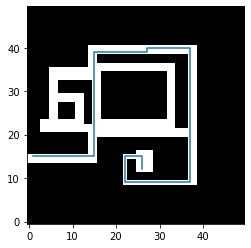

In [3]:
## Step 1: Create the world and devise robot motion
# Load in a particular environment
env = Environment("Maze1.png")
# Devise a path through that environment that passes through 3 locations
X = env.simulate_trajectory([[0, 15], [27, 40], [26, 12]])
# Plot the environment with the path superimposed
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])
 
## Step 2: Simulate scans at each position
# How many angles to sample in the range scanner
res = 50
# The noise of the scanner (start with low noise to make the problem easier)
alpha = 4
# Make this repeatably pseudorandom by seeding so that the numbers you get match up with mine
np.random.seed(0) 
# Create a list of scans.  Each scan holds a list of "res" laser ranges across all angles
observed_scans = [env.get_range_scan(X[i, :], res, alpha) for i in range(X.shape[0])]
state_scans = env.get_state_scans(res)

In [4]:
def get_measurement_prob(state_scans, observed_scans, alpha, gamma=0.1):
    probability = 1
    for i in range(len(state_scans)):
        ri = state_scans[i]
        xi = observed_scans[i]
        
        exponent = (xi-ri)**2 / (2*((alpha*ri)+gamma)*2)
        fraction = np.log(np.sqrt(2*np.pi) * ((alpha*ri) + gamma))
        probability += -exponent - fraction
               
    return probability

In [5]:
K = len(state_scans) # Number of states
T = X.shape[0] # Number of timesteps
L = np.zeros((T,K))
B = np.zeros((T,K))

for q in range(K):
    L[1,q] = np.log(1/K) + get_measurement_prob(state_scans[q], observed_scans[0], alpha)
    B[1,q] = -1
        
for n in range(1,T):   
    for k in range(K):
        maxj = -1
        maxval = -np.inf
        
        for j in env.neighbors[k]:
            val = L[n-1,j] + np.log(1/len(env.neighbors[j]))
            if val > maxval:
                maxj = j
                maxval = val
    
        L[n,k] = maxval + get_measurement_prob(state_scans[k], observed_scans[n], alpha)             
        B[n,k] = maxj

state = np.argmax(L[-1, :])
states = []     

#Subtracted 1 to keep it inbounds
n = T - 1

print(np.max(B))
while n >= 0:
    states.append(state)
    state = B[n,int(state)]
    n = n - 1
                    
states.reverse()

464.0


Text(0.5, 1.0, 'Estimated Trajectory, $\\alpha=4.000$')

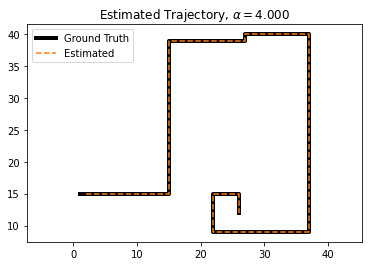

In [6]:
states = np.array(states, dtype=int)
Y = env.X[states, :]
plt.figure()
plt.plot(X[:, 0], X[:, 1], 'k', linewidth=4)
plt.plot(Y[:, 0], Y[:, 1], 'C1', linestyle='--')
plt.legend(["Ground Truth", "Estimated"])
plt.axis("equal")
plt.title("Estimated Trajectory, $\\alpha={:.3f}$".format(alpha))

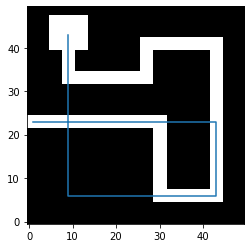

In [7]:
## ORIGINAL MAZE ATTEMPT 

env = Environment("Maze6.png")
# Devise a path through that environment that passes through 3 locations
X = env.simulate_trajectory([[0, 23], [43, 6], [9, 43]])
# Plot the environment with the path superimposed
plt.figure()
env.plot()
plt.plot(X[:, 0], X[:, 1])
 
## Step 2: Simulate scans at each position
# How many angles to sample in the range scanner
res = 50
# The noise of the scanner (start with low noise to make the problem easier)
alpha = 4
# Make this repeatably pseudorandom by seeding so that the numbers you get match up with mine
np.random.seed(0) 
# Create a list of scans.  Each scan holds a list of "res" laser ranges across all angles
observed_scans = [env.get_range_scan(X[i, :], res, alpha) for i in range(X.shape[0])]
state_scans = env.get_state_scans(res)